In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# better display of review text in dataframes
pd.set_option('display.max_colwidth', None)

# Seaborn options
sns.set(style="whitegrid", font_scale=1.4)

# Auto reload modules
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
assert tf.__version__ >= "2.0"

In [5]:
!pip install pyarrow nltk


In [9]:
import pandas as pd
import pyarrow.parquet as pq

# Load the datasets
train_data = pd.read_parquet('train-00000-of-00001.parquet', engine='pyarrow')
val_data = pd.read_parquet('validation-00000-of-00001.parquet', engine='pyarrow')
test_data = pd.read_parquet('test-00000-of-00001.parquet', engine='pyarrow')


In [10]:
print("Train columns:", train_data.columns)
print("Validation columns:", val_data.columns)
print("Test columns:", test_data.columns)


Train columns: Index(['review', 'label'], dtype='object')
Validation columns: Index(['review', 'label'], dtype='object')
Test columns: Index(['review', 'label'], dtype='object')


In [14]:
# Extract reviews
train_reviews = train_data['review'].values
val_reviews = val_data['review'].values
test_reviews = test_data['review'].values

# Concatenate all reviews
all_reviews = pd.concat([train_data['review'], val_data['review'], test_data['review']], axis=0)

# Extract labels
train_labels = train_data['label'].values
val_labels = val_data['label'].values
test_labels = test_data['label'].values

# Get class names
# This assumes your labels are integer-encoded and start from 0
class_names = np.unique(np.concatenate([train_labels, val_labels, test_labels], axis=0))


In [12]:
import nltk
from nltk.tokenize import word_tokenize

# Download the Punkt tokenizer
nltk.download('punkt')

# Tokenize the reviews
train_reviews = [word_tokenize(review) for review in train_reviews]
val_reviews = [word_tokenize(review) for review in val_reviews]
test_reviews = [word_tokenize(review) for review in test_reviews]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# **Preprocess **

In [16]:
#tokenize
MAX_NB_WORDS = 20000

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=MAX_NB_WORDS,
    oov_token="<unk>",
)
tokenizer.fit_on_texts(train_reviews)

word_index = tokenizer.word_index
print("Found {} unique tokens.".format(len(word_index)))

Found 186308 unique tokens.


In [17]:
train_reviews_tokenized = tokenizer.texts_to_sequences(train_reviews)
val_reviews_tokenized = tokenizer.texts_to_sequences(val_reviews)
test_reviews_tokenized = tokenizer.texts_to_sequences(test_reviews)

In [18]:
some_review = train_reviews_tokenized[0]
some_review[:15]

[45, 68, 4664, 17, 77, 15081, 7, 80, 9, 8746, 2505, 249, 439, 17, 1181]

In [19]:
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())
" ".join([index_to_word[i] for i in some_review[:15]])

"si vous cherchez du cinéma abrutissant à tous les étages n'ayant aucune peur du cliché"

In [21]:
import os

# Create necessary directories
os.makedirs('img/word-vectors/', exist_ok=True)

# Save the figure
fig.savefig('img/word-vectors/number_of_words.png', dpi=200)


Average length: 91.5
Max length: 389


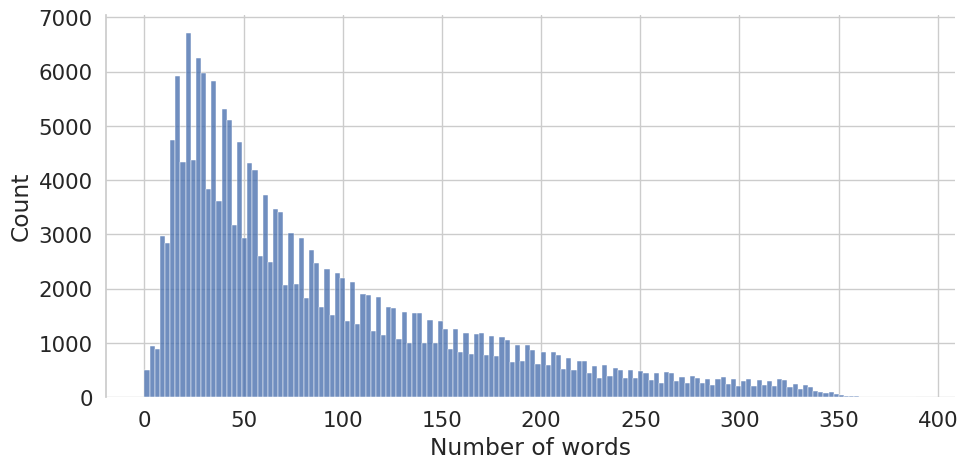

In [22]:
reviews_len = [len(s) for s in train_reviews_tokenized+val_reviews_tokenized+test_reviews_tokenized]
print("Average length: {:.1f}".format(np.mean(reviews_len)))
print("Max length: {}".format(max(reviews_len)))

plt.figure(figsize=(10,5))
ax = sns.histplot(reviews_len, bins=150, kde=False, alpha=0.8)
ax.set(xlabel='Number of words')

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig = ax.get_figure()
fig.savefig('img/word-vectors/number_of_words.png', dpi=200)

# REMOVING EMPTY SPACE

In [24]:
def remove_empty_sequences(reviews, labels):
    reviews_not_empty = []
    labels_not_empty = []
    removed = 0
    for x, y in zip(reviews, labels):
        if len(x) > 0:
            reviews_not_empty.append(x)
            labels_not_empty.append(y)
        else:
            removed += 1
    #print("Removed {} sequences !".format(removed))
    return reviews_not_empty, labels_not_empty

In [25]:
print('Removing {} empty sequences'.format(reviews_len.count(0)))

train_reviews_tokenized, train_labels = remove_empty_sequences(
    train_reviews_tokenized, train_labels
)

val_reviews_tokenized, val_labels = remove_empty_sequences(
    val_reviews_tokenized, val_labels
)

test_reviews_tokenized, test_labels = remove_empty_sequences(
    test_reviews_tokenized, test_labels
)

# Verify
reviews_len = [len(s) for s in train_reviews_tokenized+val_reviews_tokenized+test_reviews_tokenized]
assert(reviews_len.count(0) == 0)

Removing 8 empty sequences


# PADDING

Then we pad short sequences with zeros until they reach a fixed length. Long sequences are also truncated.

In [26]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_LENGTH_SEQ = 350 #

X_train = pad_sequences(
    train_reviews_tokenized,
    maxlen=MAX_LENGTH_SEQ,
    padding='post'
)

X_val = pad_sequences(
    val_reviews_tokenized,
    maxlen=MAX_LENGTH_SEQ,
    padding='post'
)

X_test = pad_sequences(
    test_reviews_tokenized,
    maxlen=MAX_LENGTH_SEQ,
    padding='post'
)

print('Shape of X_train tensor:', X_train.shape)
print('Shape of X_val tensor:', X_val.shape)
print('Shape of X_test tensor:', X_test.shape)

Shape of X_train tensor: (159993, 350)
Shape of X_val tensor: (19999, 350)
Shape of X_test tensor: (20000, 350)


# LABELS

In [27]:
y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

# Preprocessing pipeline

In order to carry out the preprocessing phase more efficiently, we can define a Scikit-Learn transformer.

In [28]:
from sklearn.base import BaseEstimator, TransformerMixin

class SequencePreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, max_nbr_words, max_seq_length):
        self.tokenizer = tf.keras.preprocessing.text.Tokenizer(
            num_words=max_nbr_words,
            oov_token="<unk>",
        )
        self.max_seq_length = max_seq_length

    # the arguments are ignored anyway, so we make them optional
    def fit(self, X):
        self.tokenizer.fit_on_texts(X)

    def transform(self, X, y):
        # 1. Tokenize
        X_tokenized = self.tokenizer.texts_to_sequences(X)
        # 2. Remove empty sequences
        X_not_empty, y_not_empty = remove_empty_sequences(X_tokenized, y)
        # 3. Pad
        X_padded = tf.keras.preprocessing.sequence.pad_sequences(
            X_not_empty,
            maxlen=self.max_seq_length,
            padding='post'
        )
        # 4. labels
        y_array = np.array(y_not_empty)
        return X_padded, y_array

    def fit_transform(self, X, y):
        self.fit(X)
        return self.transform(X, y)

# FastText

# Model

First we train an model which classify reviews based on the average vector of their embeddings.

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense

# Hyperparameters
max_features = MAX_NB_WORDS
embedding_dim = 128

model = Sequential(name='fasttext')
model.add(Embedding(max_features, embedding_dim,
                           input_shape=[None]),)
model.add(GlobalAveragePooling1D())
model.add(Dense(1, activation="sigmoid"))

model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [30]:
initial_weights = model.get_weights()
model.summary()

Model: "fasttext"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2560000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2560129 (9.77 MB)
Trainable params: 2560129 (9.77 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Training

In [31]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath='data/word-vectors/fasttext_weights.hdf5',
    save_best_only=True, verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10, batch_size=128,
    callbacks=[checkpointer], verbose=1)

Epoch 1/10
1250/1250 [==============================] - ETA: 0s - loss: 0.4684 - accuracy: 0.8231
Epoch 1: val_loss improved from inf to 0.29810, saving model to data/word-vectors/fasttext_weights.hdf5
1250/1250 [==============================] - 64s 50ms/step - loss: 0.4684 - accuracy: 0.8231 - val_loss: 0.2981 - val_accuracy: 0.9064
Epoch 2/10
   2/1250 [..............................] - ETA: 1:27 - loss: 0.3328 - accuracy: 0.8828

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1250/1250 [==============================] - ETA: 0s - loss: 0.2544 - accuracy: 0.9128
Epoch 2: val_loss improved from 0.29810 to 0.23567, saving model to data/word-vectors/fasttext_weights.hdf5
1250/1250 [==============================] - 63s 51ms/step - loss: 0.2544 - accuracy: 0.9128 - val_loss: 0.2357 - val_accuracy: 0.9162
Epoch 3/10
1249/1250 [============================>.] - ETA: 0s - loss: 0.2052 - accuracy: 0.9263
Epoch 3: val_loss improved from 0.23567 to 0.20873, saving model to data/word-vectors/fasttext_weights.hdf5
1250/1250 [==============================] - 63s 50ms/step - loss: 0.2052 - accuracy: 0.9263 - val_loss: 0.2087 - val_accuracy: 0.9256
Epoch 4/10
1249/1250 [============================>.] - ETA: 0s - loss: 0.1832 - accuracy: 0.9331
Epoch 4: val_loss improved from 0.20873 to 0.20236, saving model to data/word-vectors/fasttext_weights.hdf5
1250/1250 [==============================] - 62s 50ms/step - loss: 0.1832 - accuracy: 0.9331 - val_loss: 0.2024 - val_accur

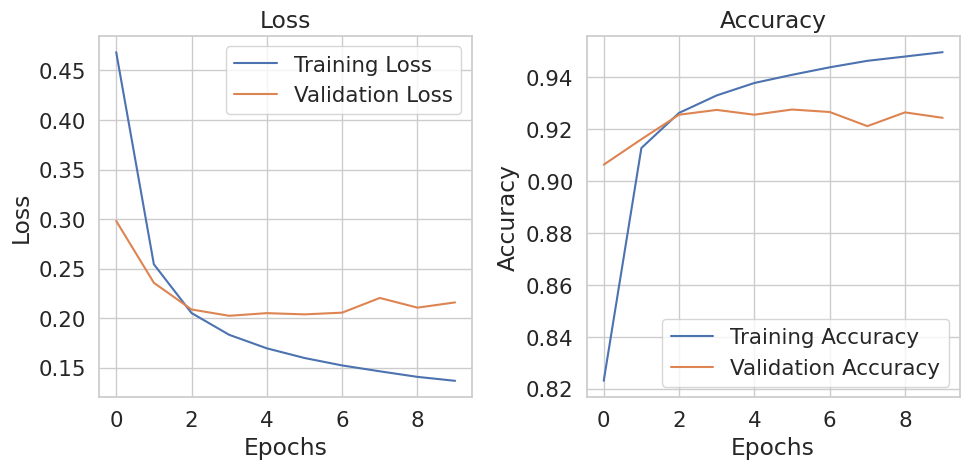

In [33]:
import matplotlib.pyplot as plt

# Assuming 'history' is a History object returned from the fit method of a keras model
# history.history should be a dictionary with keys 'loss' and 'val_loss' for loss values
# and 'accuracy' and 'val_accuracy' for accuracy values

# Plotting loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('img/word-vectors/fasttext_training.png', dpi=200)
plt.show()


In [35]:
from sklearn import metrics

probas = model.predict(X_val)
y_pred = (probas > 0.5).astype(int)  # Changed np.int to int

print("Val Accuracy: {:.2f}".format(100 * metrics.accuracy_score(y_val, y_pred)))
print("Val F1-Score: {:.2f}".format(100 * metrics.f1_score(y_val, y_pred)))


625/625 [==============================] - 3s 4ms/step
Val Accuracy: 92.44
Val F1-Score: 92.21


# Testing

In [37]:
model.load_weights('data/word-vectors/fasttext_weights.hdf5')

probas = model.predict(X_test)
y_pred = (probas > 0.5).astype(int)

625/625 [==============================] - 3s 4ms/step


In [40]:
print("Test Accuracy: {:.2f}".format(100 * metrics.accuracy_score(y_test, y_pred)))
print("Test F1-Score: {:.2f}".format(100 * metrics.f1_score(y_test, y_pred)))
print()

# Convert class numbers to strings
class_names_str = class_names.astype(str)

report = metrics.classification_report(
    y_test, y_pred,
    target_names=class_names_str  # Use string class names
)
print(report)



Test Accuracy: 92.86
Test F1-Score: 92.57

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     10408
           1       0.92      0.93      0.93      9592

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000



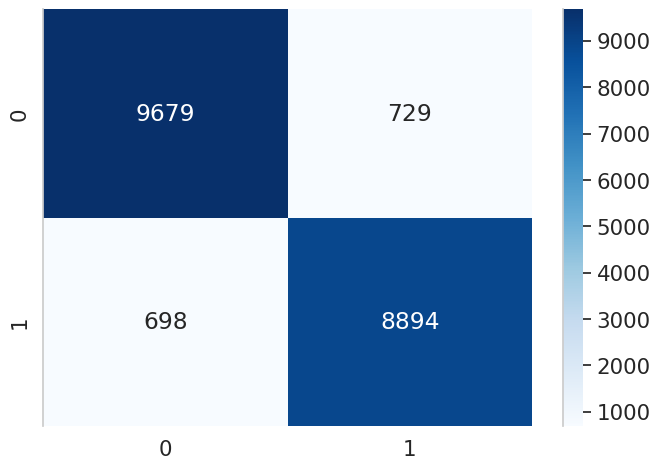

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_mx = confusion_matrix(y_test, y_pred)

# Convert class names to strings if they are not already
class_names_str = [str(cls) for cls in class_names]

# Create a DataFrame from the confusion matrix for easier plotting
conf_mx_df = pd.DataFrame(conf_mx, index=class_names_str, columns=class_names_str)

# Create the plot
plt.figure(figsize=(7,5))
sns.heatmap(conf_mx_df, annot=True, fmt='d', cmap='Blues')

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Save the plot
plt.savefig('img/word-vectors/fastext_test_confusion_mx.png', dpi=200)
plt.show()


# Accuracy vs Training data

In [49]:
from sklearn.base import BaseEstimator

class EarlyStoppingModel(BaseEstimator):
    def __init__(self, keras_model, max_epoches, batch_size, validation_data):
        self.model = keras_model
        self.max_epoches = max_epoches
        self.batch_size = batch_size
        self.validation_data = validation_data

    def fit(self, X, y):
        # Defines early stopper
        early_stopper = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', mode='auto', patience=3,
            verbose=1, restore_best_weights=True
        )

        # Train model on data subset
        self.model.fit(
            X, y,
            validation_data=self.validation_data,
            epochs=self.max_epoches,
            batch_size=self.batch_size,
            callbacks=[early_stopper],
            verbose=2
        )
        return self

    def predict(self, X):
        probas = self.model.predict(X)
        y_pred = (probas > 0.5).astype(int)
        return y_pred

In [50]:
from sklearn import metrics

def accuracy_vs_training_data(keras_model, initial_weights,
                              preprocessor, sizes,
                              train_reviews, train_labels,
                              val_reviews, val_labels,
                              test_reviews, test_labels):
    test_accuracies = []
    for size in sizes:
        # Preprocess data
        X_train, y_train = preprocessor.fit_transform(
            train_reviews[:size], train_labels[:size]
        )
        X_val, y_val = preprocessor.transform(val_reviews, val_labels)
        X_test, y_test = preprocessor.transform(test_reviews, test_labels)

        # Reset weights to initial value
        keras_model.set_weights(initial_weights)
        best_model = EarlyStoppingModel(
            keras_model, max_epoches=100, batch_size=64,
            validation_data=(X_val, y_val)
        )

        # Train model
        best_model.fit(X_train, y_train)

        # Evaluate on test set
        y_pred = best_model.predict(X_test)
        test_acc = metrics.accuracy_score(y_test, y_pred)
        test_accuracies.append(test_acc)

    return test_accuracies

In [51]:
sizes = [int(p) for p in np.geomspace(1000, 160000, 10)]
preprocessor = SequencePreprocessor(MAX_NB_WORDS, MAX_LENGTH_SEQ)

test_accuracies = accuracy_vs_training_data(
    model, initial_weights,
    preprocessor, sizes,
    train_reviews, train_labels,
    val_reviews, val_labels,
    test_reviews, test_labels
)


Epoch 1/100
16/16 - 2s - loss: 0.6926 - accuracy: 0.5360 - val_loss: 0.6930 - val_accuracy: 0.5108 - 2s/epoch - 113ms/step
Epoch 2/100
16/16 - 2s - loss: 0.6915 - accuracy: 0.5250 - val_loss: 0.6929 - val_accuracy: 0.5110 - 2s/epoch - 112ms/step
Epoch 3/100
16/16 - 2s - loss: 0.6904 - accuracy: 0.5340 - val_loss: 0.6929 - val_accuracy: 0.5109 - 2s/epoch - 112ms/step
Epoch 4/100
16/16 - 2s - loss: 0.6890 - accuracy: 0.5460 - val_loss: 0.6930 - val_accuracy: 0.5117 - 2s/epoch - 113ms/step
Epoch 5/100
16/16 - 3s - loss: 0.6881 - accuracy: 0.5410 - val_loss: 0.6933 - val_accuracy: 0.5111 - 3s/epoch - 193ms/step
Epoch 6/100
Restoring model weights from the end of the best epoch: 3.
16/16 - 2s - loss: 0.6865 - accuracy: 0.5460 - val_loss: 0.6933 - val_accuracy: 0.5117 - 2s/epoch - 115ms/step
Epoch 6: early stopping
625/625 [==============================] - 2s 3ms/step
Epoch 1/100
28/28 - 3s - loss: 0.6930 - accuracy: 0.5117 - val_loss: 0.6930 - val_accuracy: 0.5117 - 3s/epoch - 103ms/step
E

In [ ]:
!pip install fastparquet


In [53]:
import pandas as pd

OUTPUT_PATH = 'data/word-vectors/fasttext_accuracies.parquet'

output_dict = {
    "sizes": sizes,
    "test_accuracies": test_accuracies
}

# Convert the dictionary to a DataFrame
output_df = pd.DataFrame(output_dict)

# Save the DataFrame to a Parquet file
output_df.to_parquet(OUTPUT_PATH)


# Inference time

In [54]:
model.load_weights('data/word-vectors/fasttext_weights.hdf5')

In [55]:
import time

inference_times = []

for i in range(1000):
    x = np.array([X_test[i], ])
    start_time = time.time()
    y_pred = model.predict(x)
    stop_time = time.time()

    inference_times.append(stop_time - start_time)

1/1 [==============================] - 0s 18ms/step


In [56]:
import pandas as pd

OUTPUT_PATH = 'data/word-vectors/fasttext_times.parquet'

# Convert the list to a DataFrame
inference_times_df = pd.DataFrame(inference_times, columns=['inference_times'])

# Save the DataFrame to a Parquet file
inference_times_df.to_parquet(OUTPUT_PATH)


# Generalizability

In [61]:
import pandas as pd

# Define the folder paths
ACL_FOLDER = 'data/cls-acl10-unprocessed/fr'
BOOKS_FOLDER = os.path.join(ACL_FOLDER, 'books')
DVD_FOLDER = os.path.join(ACL_FOLDER, 'dvd')
MUSIC_FOLDER = os.path.join(ACL_FOLDER, 'music')

# Define a function to load the data
def load_data(folder_path):
    # Assuming the data is in a CSV file named 'data.csv'
    data_path = os.path.join(folder_path, 'data.csv')
    data = pd.read_csv(data_path)

    # Assuming the reviews are in a column named 'review'
    # and the labels are in a column named 'label'
    reviews = data['review']
    labels = data['label']

    return reviews, labels

# Load the data
test_reviews_b, test_labels_b = load_data(BOOKS_FOLDER)
test_reviews_d, test_labels_d = load_data(DVD_FOLDER)
test_reviews_m, test_labels_m = load_data(MUSIC_FOLDER)


FileNotFoundError: [Errno 2] No such file or directory: 'data/cls-acl10-unprocessed/fr/books/data.csv'

In [59]:
from sklearn import metrics

def evaluate(model, X, y):
    probas = model.predict(X)
    y_pred = (probas > 0.5).astype(int)
    print("Accuracy: {:.2f}".format(100 * metrics.accuracy_score(y, y_pred)))
    print("F1-Score: {:.2f}".format(100 * metrics.f1_score(y, y_pred)))

In [60]:
preprocessor = SequencePreprocessor(MAX_NB_WORDS, MAX_LENGTH_SEQ)
preprocessor.fit(train_reviews)